In [124]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [125]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [126]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [17]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [127]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\parme\AppData\Local\Temp\ipykernel_24564\1526636886.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [128]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [129]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [130]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [131]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [132]:
# Starting from the most recent data point in the database. 
# Query to find the most recent date in the 'date' column of the 'Measurement' table
query_most_recent_date = "SELECT MAX(date) AS most_recent_date FROM Measurement"

# Execute the query to find the most recent date
df_most_recent_date = pd.read_sql(query_most_recent_date, engine)

# Display the most recent date
most_recent_date = df_most_recent_date['most_recent_date'].iloc[0]
print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


In [133]:
# Query to calculate the date one year before the maximum date in the 'date' column
query_one_year_ago_date = """
    SELECT DATE(MAX(date), '-1 year') AS one_year_ago_date
    FROM Measurement
"""

# Execute the query and store the result in a DataFrame
df_one_year_ago_date = pd.read_sql(query_one_year_ago_date, engine)

# Display the calculated date one year ago
print(df_one_year_ago_date)

  one_year_ago_date
0        2016-08-23


In [135]:
# Perform a query to retrieve the data and precipitation scores for the last 12 months
query_last_12_months = """
    SELECT date, prcp
    FROM Measurement
    WHERE date >= (SELECT DATE(MAX(date), '-1 year') FROM Measurement)
"""

# Execute the query and store the result in a DataFrame
df_last_12_months_data = pd.read_sql(query_last_12_months, engine)

# Display the query result (data and precipitation scores for the last 12 months)
print(df_last_12_months_data)

            date  prcp
0     2016-08-23  0.00
1     2016-08-24  0.08
2     2016-08-25  0.08
3     2016-08-26  0.00
4     2016-08-27  0.00
...          ...   ...
2225  2017-08-19  0.09
2226  2017-08-20   NaN
2227  2017-08-21  0.56
2228  2017-08-22  0.50
2229  2017-08-23  0.45

[2230 rows x 2 columns]


In [136]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# # Execute the query and store the result in a DataFrame
df_last_12_months = pd.read_sql(query_last_12_months, engine)

# Explicitly set the column names
df_last_12_months.columns = ['Date', 'Precipitation']

# Display the query result with the updated column names
print(df_last_12_months.head())

         Date  Precipitation
0  2016-08-23           0.00
1  2016-08-24           0.08
2  2016-08-25           0.08
3  2016-08-26           0.00
4  2016-08-27           0.00


In [137]:
# Sort the dataframe by date
df_last_12_months_sorted = df_last_12_months.sort_values('Date')

# Print the sorted DataFrame
print(df_last_12_months_sorted.head())

            Date  Precipitation
0     2016-08-23           0.00
1009  2016-08-23            NaN
1529  2016-08-23           1.79
704   2016-08-23           0.05
361   2016-08-23           0.15


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8')])

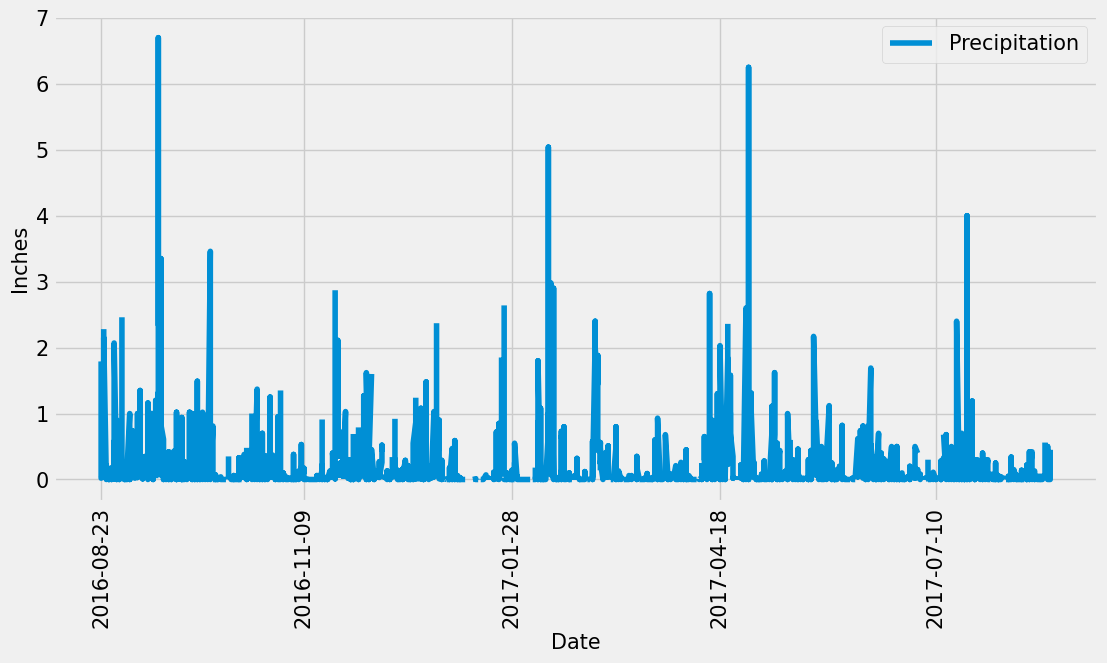

In [138]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(12, 6))
plt.plot(df_last_12_months_sorted['Date'], df_last_12_months_sorted['Precipitation'], label='Precipitation')

plt.legend(['Precipitation'], loc="upper right",fontsize=15)

# set x location
xloc = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10'] 

# xticks
plt.xticks(xloc, rotation='vertical',fontsize=15)

# Labels
plt.xlabel('Date', fontsize=15)
plt.ylabel("Inches",fontsize=15)
plt.yticks(size=15)

In [139]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df_last_12_months_sorted['Precipitation'].describe()
print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [140]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations:", total_stations)

Total number of stations: 9


In [141]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = [Measurement.station, func.count(Measurement.date)]

# Query to find the most active stations and their observation counts in descending order
active_stations = session.query(*most_active_stations).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [142]:
from sqlalchemy import func



In [143]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Get the most active station ID from the previous query result
most_active_station_id = active_stations[0][0]

# Define the columns for the query
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

# Query to calculate the lowest, highest, and average temperature for the most active station
results = session.query(*sel).filter(Measurement.station == most_active_station_id).all()

# Extract the results
for result in results:
    min_temp, max_temp, avg_temp = result
    print(f"[(Lowest Temperature: {min_temp}, Highest Temperature: {max_temp}, Average Temperature: {avg_temp})]")

[(Lowest Temperature: 54.0, Highest Temperature: 85.0, Average Temperature: 71.66378066378067)]


In [144]:
from datetime import datetime, timedelta

In [145]:
 #Query the last 12 months of temperature observation data for the most active station
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = datetime.strptime(last_date[0], '%Y-%m-%d')
one_year_ago = last_date - timedelta(days=365)
df_one_year_ago_date = one_year_ago.strftime('%Y-%m-%d')

# Query the last 12 months of temperature observation data for the most active station
sel = [Measurement.date, Measurement.tobs]
station_temps = session.query(*sel).\
    filter(Measurement.date >= df_one_year_ago_date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date).all()

# Load the results into a Pandas DataFrame
station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])

# Display the first 12 rows of the DataFrame
station_temps_df.head(12)

,Measurement Date,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
5,2016-08-28,73.0
6,2016-08-29,78.0
7,2016-08-30,77.0
8,2016-08-31,78.0
9,2016-09-01,80.0


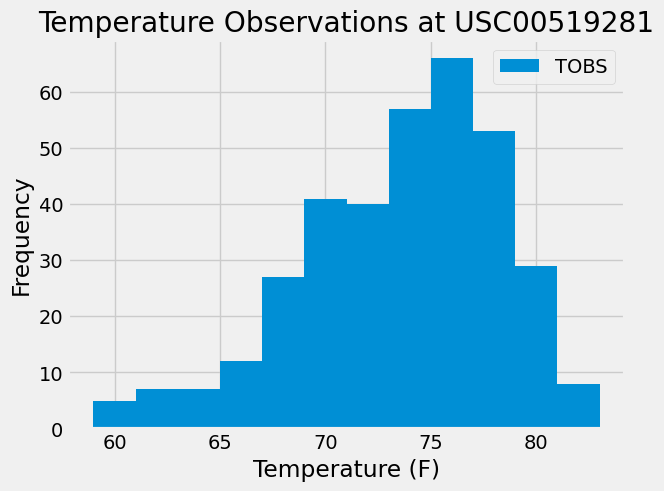

In [146]:
#plot the results as a histogram
plt.hist(station_temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at USC00519281")
plt.figsize=(10,7)
plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()


# Close Session

In [147]:
# Close Session
session.close()